# LangGraph Tutorial

## One Agent and Multiple Tools v.1
* Start with an agent, `run_agent`
* Agent make a decision to call a function/tool
* If so, then `action` to call tool (ToolExecutor)
* Then call agent with the tool output added to intermediate_steps (`state`)

#### Initiate LLM 

In [1]:
from langchain_google_vertexai import ChatVertexAI
llm = ChatVertexAI(
                    model_name= 'gemini-1.5-flash-preview-0514',
                    temperature= 0.0,
                    top_p=0.8,
                    top_k=40,
                    verbose= True,
                    convert_system_message_to_human=False,
                    streaming = True)


#### Define simple tools using LangChain

This @tool decorator is the simplest way to define a custom tool. <br> 
The decorator uses the function name as the tool name by default, but this can be overridden <br> 
by passing a string as the first argument. Additionally, the decorator will use the <br> 
function's docstring as the tool's description - so a docstring MUST be provided.

In [2]:
from langchain.tools import tool


# setup the simple tools using LangChain tool decorator
@tool
def add(a: int, b: int) -> int:
    """Add two numbers."""
    return a + b


@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers."""
    return a * b


@tool
def square(a: int) -> int:
    """Calculates the square of a number."""
    a = int(a)
    return a * a

# setup the toolkit
toolkit = [add, multiply, square]



Inspecting the tools

In [3]:
print(multiply.name)
print(multiply.description)
print(multiply.args)
print(multiply.return_direct)
print(multiply.args_schema.schema())

multiply
Multiply two numbers.
{'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}
False
{'title': 'multiplySchema', 'description': 'Multiply two numbers.', 'type': 'object', 'properties': {'a': {'title': 'A', 'type': 'integer'}, 'b': {'title': 'B', 'type': 'integer'}}, 'required': ['a', 'b']}


## LangGraph Nodes

A node can be either a function or a runnable (such as an agent, chain etc.) <br>
When a node is invoked the function/runnable it corresponds to will receive <br>
the graph state (information about past, present, other nodes etc.) <br>
The executed node will then update the graph state with its return value. 

#### Create Agent Runnables (Tool Calling and Structured Output)

Tool Calling Agent

In [4]:
from langchain.agents import create_tool_calling_agent

from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

#define system prompt for tool calling agent
system_prompt = """ You are a mathematical assistant.
        Use your tools to answer questions. If you do not have a tool to
        answer the question, say so. """

tool_calling_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder("chat_history", optional=True),
        ("human", "{input}"),
        MessagesPlaceholder("agent_scratchpad"),
    ]
)

tool_runnable = create_tool_calling_agent(llm, toolkit, prompt  = tool_calling_prompt)




Structured Output Agent

In [5]:
from langchain.agents import create_structured_chat_agent
from langchain import hub

#define system prompt for structured agent - ReAct
# you can read the prompt here https://smith.langchain.com/hub/hwchase17/structured-chat-agent

structured_agent_prompt = hub.pull("hwchase17/structured-chat-agent")

#add custom system message to the default prompt
structured_agent_prompt.messages[0].prompt.template = system_prompt + structured_agent_prompt.messages[0].prompt.template

# Construct the structured tools agent
sca_runnable = create_structured_chat_agent(llm, toolkit, prompt  = structured_agent_prompt)



Agent runnables return the AgentAction / Tool Agent Action variable which <br> 
defines but does not execute the next step the agent is going to take <br>
The next agent action state will be updated in the graph state

In [6]:
#returns a list of tool actions
tool_actions = tool_runnable.invoke({"input": "hi! what's 1+1 and  2 times 2", 'intermediate_steps': []})

#returns only one action
sca_action = sca_runnable.invoke({"input": "hi! what's 1+1 and  2 times 2", 'intermediate_steps': []})


This model can reply with multiple function calls in one response. Please don't rely on `additional_kwargs.function_call` as only the last one will be saved.Use `tool_calls` instead.


Node Functions for Agent Invocations

In [8]:
# Define the agent invocation functions
# Define which state variable the invocation will read/affect

def run_tool_agent(state):
    agent_outcome = tool_runnable.invoke(state)

    #this agent will overwrite the agent outcome state variable
    return {"agent_outcome": agent_outcome}

def run_sca_agent(state):
    agent_outcome = sca_runnable.invoke(state)

    #this agent will overwrite the agent outcome state variable
    return {"agent_outcome": agent_outcome}


#### Create Tool Executor

When this node is called the tool specified in the state <br>
will be invoked and the state will be updated with its result

In [9]:
from langgraph.prebuilt.tool_executor import ToolExecutor

# tool executor invokes the tool action specified from the agent runnable
# they will become the nodes that will be called when the agent decides on a tool action.

tool_executor = ToolExecutor(toolkit)

#displaying the tool invocation
for action in tool_actions:
    print(f'Action results from tool calling agent: {tool_executor.invoke(action)}')


print(f'Action results from structured chat agent: {tool_executor.invoke(sca_action)}')


Action results from tool calling agent: 2
Action results from tool calling agent: 4
Action results from structured chat agent: 2


Node Function for Tool Invocation

In [10]:
# Define the function to execute tools
# This node will run a different tool as specified in the state variable agent_outcome
def execute_tools(data):
    # Get the most recent agent_outcome - this is the key added in the `agent` above
    agent_action = data['agent_outcome']
    if type(agent_action) is not list:
        agent_action = [agent_action]
    steps = []
    #sca only returns an action while tool calling returns a list
    # convert single actions to a list
    
    for action in agent_action:
    # Execute the tool
        output = tool_executor.invoke(action)
        print(f"The agent action is {action}")
        print(f"The tool result is: {output}")
        steps.append((action, str(output)))
    # Return the output
    return {"intermediate_steps": steps}

## Graph State

LangGraph passes around information between agents and tools using a state variable <br>
The state variable in this example will contain the human input, chat history, intermediate_steps and agent_action <br>
The valid variable types must be defined for each state variable.

In [11]:
from typing import TypedDict, Annotated,Union
from langchain_core.agents import AgentAction, AgentFinish
from langchain.agents.output_parsers.tools import ToolAgentAction
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
   # The input string from human
   input: str
   # The list of previous messages in the conversation
   chat_history: list[BaseMessage]
   # The outcome of a given call to the agent
   # Needs 'list' as a valid type as the tool agent returns a list.
   # Needs `None` as a valid type, since this is what this will start as
   # this state will be overwritten with the latest everytime the agent is run
   agent_outcome: Union[AgentAction, list, ToolAgentAction, AgentFinish, None]

   # List of actions and corresponding observations
   # These actions should be added onto the existing so we use `operator.add` 
   # to append to the list of past intermediate steps
   intermediate_steps: Annotated[list[Union[tuple[AgentAction, str], tuple[ToolAgentAction, str]]], operator.add]

### Edge Logic

Edges direct to the next node to invoke given the current node and state. <br>
Edges can be static: if at node 1 go to node 2 <br>
Edges can be conditional: if at node 1, go to the node the edge logic specifies.<br>
Edge logic can be defined using functions with if else statements

In [12]:
# Define the flow logic of the graph, 
# Here we define the logic that determines if we should continue 
# If agent determines that the human task is done, it returns AgentFinish and 
# we terminate the graph invocations

def should_continue(data):
    # If the agent outcome is an AgentFinish, then we return `exit` string
    # This will be used when setting up the graph to define the flow
    if isinstance(data['agent_outcome'], AgentFinish):
        return "END"
    # Otherwise, an AgentAction is returned
    # Here we return `continue` string
    # This will be used when setting up the graph to define the flow
    else:
        return "CONTINUE"


## Build the Graph

In [18]:
from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(AgentState)

# When nodes are called, the functions corresponding to the tools will be called. 
# Pick whatever agent you choose and add the node to the graph
workflow.add_node("agent", run_sca_agent)

# for the tool calling agent uncomment the next line
#workflow.add_node("agent", run_tool_agent)


# Add tool invocation node to the graph
workflow.add_node("action", execute_tools)

# Define which node the graph will invoke at start.
workflow.set_entry_point("agent")

# Add flow logic with static edge.
# Each time a tool is invoked and completed we want to 
# return the result to the agent to assess if task is complete or to take further actions 

#each action invocation has an edge leading to the agent node.
workflow.add_edge('action', 'agent')


# Add flow logic with conditional edge.
workflow.add_conditional_edges(
    # first parameter is the starting node for the edge
    "agent",
    # the second parameter specifies the logic function to be run
    # to determine which node the edge will point to given the state.
    should_continue,

    #third parameter defines the mapping between the logic function 
    #output and the nodes on the graph
    # For each possible output of the logic function there must be a valid node.
    {
        # If 'continue' we proceed to the action node.
        "CONTINUE": "action",
        # Otherwise we end invocations with the END node.
        "END": END
    }
)


### Adding Memory

by setting a checkpointer when compiling the graph and a thread_id when <br>
calling your graph, LangGraph automatically saves the state after each step. <br>
When you invoke the graph again using the same thread_id, the graph loads its <br>
saved state, allowing the chatbot to pick up where it left off.

In [14]:
from langgraph.checkpoint import MemorySaver

memory = MemorySaver()

# Finally, compile the graph! 
# This compiles it into a LangChain Runnable,
app = workflow.compile(checkpointer = memory)

### Visualise the Graph

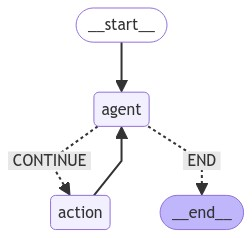

In [15]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### Test Run the Graph by Streaming

In [16]:
inputs = {"input": "give me 1+1 and then 2 times 2", "chat_history": []} 
config = {"configurable": {"thread_id": "1"}}

for s in app.stream(inputs, config = config):
    print(list(s.values())[0])
    print("----")

{'agent_outcome': AgentAction(tool='add', tool_input={'a': 1, 'b': 1}, log='```json\n{\n  "action": "add",\n  "action_input": {\n    "a": 1,\n    "b": 1\n  }\n}\n```')}
----
The agent action is tool='add' tool_input={'a': 1, 'b': 1} log='```json\n{\n  "action": "add",\n  "action_input": {\n    "a": 1,\n    "b": 1\n  }\n}\n```'
The tool result is: 2
{'intermediate_steps': [(AgentAction(tool='add', tool_input={'a': 1, 'b': 1}, log='```json\n{\n  "action": "add",\n  "action_input": {\n    "a": 1,\n    "b": 1\n  }\n}\n```'), '2')]}
----
{'agent_outcome': AgentAction(tool='multiply', tool_input={'a': 2, 'b': 2}, log='```json\n{\n  "action": "multiply",\n  "action_input": {\n    "a": 2,\n    "b": 2\n  }\n}\n```')}
----
The agent action is tool='multiply' tool_input={'a': 2, 'b': 2} log='```json\n{\n  "action": "multiply",\n  "action_input": {\n    "a": 2,\n    "b": 2\n  }\n}\n```'
The tool result is: 4
{'intermediate_steps': [(AgentAction(tool='multiply', tool_input={'a': 2, 'b': 2}, log='``

Test Memory is Working

In [21]:
inputs = {"input": "what was the last result", "chat_history": []} 
config = {"configurable": {"thread_id": "1"}}

for s in app.stream(inputs, config = config):
    print(list(s.values())[0])
    print("----")

{'agent_outcome': AgentFinish(return_values={'output': 'The last result was 4.'}, log='```json\n{\n  "action": "Final Answer",\n  "action_input": "The last result was 4."\n}\n```')}
----


Invoke Graph without Streaming just for the Output

In [22]:
inputs = {"input": "give me 1+1 and then 2 times 2", "chat_history": []} 
config = {"configurable": {"thread_id": "2"}}
output = app.invoke(inputs, config = config)
print(output)

The agent action is tool='add' tool_input={'a': 1, 'b': 1} log='```json\n{\n  "action": "add",\n  "action_input": {\n    "a": 1,\n    "b": 1\n  }\n}\n```'
The tool result is: 2
The agent action is tool='multiply' tool_input={'a': 2, 'b': 2} log='```json\n{\n  "action": "multiply",\n  "action_input": {\n    "a": 2,\n    "b": 2\n  }\n}\n```'
The tool result is: 4
{'input': 'give me 1+1 and then 2 times 2', 'chat_history': [], 'agent_outcome': AgentFinish(return_values={'output': '1+1 is 2, and 2 times 2 is 4.'}, log='```json\n{\n  "action": "Final Answer",\n  "action_input": "1+1 is 2, and 2 times 2 is 4."\n}\n```'), 'intermediate_steps': [(AgentAction(tool='add', tool_input={'a': 1, 'b': 1}, log='```json\n{\n  "action": "add",\n  "action_input": {\n    "a": 1,\n    "b": 1\n  }\n}\n```'), '2'), (AgentAction(tool='multiply', tool_input={'a': 2, 'b': 2}, log='```json\n{\n  "action": "multiply",\n  "action_input": {\n    "a": 2,\n    "b": 2\n  }\n}\n```'), '4')]}


## One Agent Multiple Tools v.2

Invoke the LLM with binded Tools
* Start with an LLM with tools, `invoke_LLM`
* LLM makes a decision to call a function/tool
* If so, then `action` to call tool (ToolExecutor)
* Then call LLM with the tool output added to messages (`state`)

In [23]:
llm_w_tools = llm.bind_tools(toolkit)
llm_output = llm_w_tools.invoke('1+1 and 2*2')

#display invocation output
print(llm_output)
#display type of message returned
print(type(llm_output))

This model can reply with multiple function calls in one response. Please don't rely on `additional_kwargs.function_call` as only the last one will be saved.Use `tool_calls` instead.


content='' additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 2.0}'}} response_metadata={'is_blocked': False, 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability_label': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability_label': 'NEGLIGIBLE', 'blocked': False}]} id='run-26d76e8c-e481-4387-82bd-0419b367050a-0' tool_calls=[{'name': 'add', 'args': {'a': 1.0, 'b': 1.0}, 'id': '3c33db72-d416-4ae6-8e95-795ee7b59192', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 2.0, 'b': 2.0}, 'id': 'eaed2556-574a-4ea1-9714-8a4c4a4b8a24', 'type': 'tool_call'}] usage_metadata={'input_tokens': 53, 'output_tokens': 6, 'total_tokens': 59}
<class 'langchain_core.messages.ai.AIMessage'>


Tool invocations will be in tool_calls, the latest tool call will be under additional kwargs, function_call

In [24]:
print(llm_output.tool_calls)
print(llm_output.additional_kwargs['function_call'])

[{'name': 'add', 'args': {'a': 1.0, 'b': 1.0}, 'id': '3c33db72-d416-4ae6-8e95-795ee7b59192', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 2.0, 'b': 2.0}, 'id': 'eaed2556-574a-4ea1-9714-8a4c4a4b8a24', 'type': 'tool_call'}]
{'name': 'multiply', 'arguments': '{"a": 2.0, "b": 2.0}'}


Agent and Tool Nodes

In [25]:
from langgraph.prebuilt import ToolInvocation
from langchain_core.messages import FunctionMessage

#invoke LLM node
def invoke_LLM(state):
    #read the message history
    messages = state['messages']
    response = llm_w_tools.invoke(messages)
    #update messages state by appending the latest response
    return {'messages': [response]}


tool_executor = ToolExecutor(toolkit)

#invoke tool node
def call_tool(state):
    #read message history
    messages = state['messages']

    #if latest message is an AI message calling tools, invoke them.
    last_message = messages[-1]
    function_messages = []
    tool_calls = last_message.tool_calls
    for tool_call in tool_calls:
        action = ToolInvocation(tool = tool_call['name'], 
                                tool_input= tool_call['args'])
        response = tool_executor.invoke(action)
        #print(f'tool result is {response}')
        function_message = FunctionMessage(content = str(response), name = action.tool)
        function_messages.append(function_message)
    return {'messages': function_messages}


In [26]:
#display tool calling node output
print(call_tool({'messages': [llm_output]}))

{'messages': [FunctionMessage(content='2', name='add'), FunctionMessage(content='4', name='multiply')]}


#### Graph State
All information we need to run the graph will be in the messages passed <br>
between the user and the AI so we only need one state variable

In [27]:
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
import operator


class AgentState(TypedDict):
   #a list of messages sent between the agent and user.
   #can be a human message, can be an AI message
   #new messages will be appended to the list.
   messages: Annotated[Sequence[BaseMessage], operator.add]


#### Edge Logic

In [28]:
def should_continue(state):

    messages = state['messages']
    last_message = messages[-1]

    #if no tool is called agent can respond to the query 
    #on its own therefore the agent invocation is the end

    #otherwise we continue to tools

    if 'function_call' not in last_message.additional_kwargs:
        return 'END'
    else:
        return 'CONTINUE'
    

In [29]:
from langgraph.graph import StateGraph, END
# Define a new graph
workflow = StateGraph(AgentState)

# Define the two nodes we will cycle between
workflow.add_node("LLM", invoke_LLM)
workflow.add_node("action", call_tool)

# Set the entrypoint as `agent` where we start
workflow.set_entry_point("LLM")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "LLM",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "CONTINUE": "action",
        # Otherwise we finish.
        "END": END
    }
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge('action', 'LLM')

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile()

In [30]:
from langchain_core.messages import HumanMessage, SystemMessage

# Can add system message for the LLM 
system_message = SystemMessage(content="You are a helpful calculator assistant")
human_message = HumanMessage(content="what is 1+1 and 2*2")


inputs = {"messages": [system_message,human_message]}

app.invoke(inputs)

This model can reply with multiple function calls in one response. Please don't rely on `additional_kwargs.function_call` as only the last one will be saved.Use `tool_calls` instead.


{'messages': [SystemMessage(content='You are a helpful calculator assistant'),
  HumanMessage(content='what is 1+1 and 2*2'),
  AIMessage(content='', additional_kwargs={'function_call': {'name': 'multiply', 'arguments': '{"a": 2.0, "b": 2.0}'}}, response_metadata={'is_blocked': False, 'safety_ratings': [{'category': 'HARM_CATEGORY_HATE_SPEECH', 'probability_label': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_DANGEROUS_CONTENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_HARASSMENT', 'probability_label': 'NEGLIGIBLE', 'blocked': False}, {'category': 'HARM_CATEGORY_SEXUALLY_EXPLICIT', 'probability_label': 'NEGLIGIBLE', 'blocked': False}]}, id='run-ccbc44c3-2bd6-41c4-ae7f-3023d7e0171a-0', tool_calls=[{'name': 'add', 'args': {'a': 1.0, 'b': 1.0}, 'id': '99528dca-0721-4afe-8bb0-fea574462c46', 'type': 'tool_call'}, {'name': 'multiply', 'args': {'a': 2.0, 'b': 2.0}, 'id': '4c405995-104f-4b6c-b9f0-f5b98951b70d', 'type': 'tool_call'}], usa

#### Visualise Agent

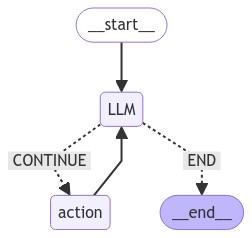

In [31]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass